In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
import os 
import warnings
from itertools import product
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import make_scorer, mean_squared_error

In [2]:
qubits = 3
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
os.environ["PL_GLOBAL_SEED"] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
algorithm_globals.random_seed = seed
features_size = 3
#window_size = features_size * 3
window_size = 10
predict_size = 1
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [3]:
dfi = pd.read_csv('./Data/Weather/city_hour.csv')
dfi

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01 01:00:00,NaN,NaN,1.00,40.01,36.37,NaN,1.00,122.07,NaN,0.0,0.0,0.0,NaN,NaN
1,Ahmedabad,2015-01-01 02:00:00,NaN,NaN,0.02,27.75,19.73,NaN,0.02,85.90,NaN,0.0,0.0,0.0,NaN,NaN
2,Ahmedabad,2015-01-01 03:00:00,NaN,NaN,0.08,19.32,11.08,NaN,0.08,52.83,NaN,0.0,0.0,0.0,NaN,NaN
3,Ahmedabad,2015-01-01 04:00:00,NaN,NaN,0.30,16.45,9.20,NaN,0.30,39.53,153.58,0.0,0.0,0.0,NaN,NaN
4,Ahmedabad,2015-01-01 05:00:00,NaN,NaN,0.12,14.90,7.85,NaN,0.12,32.63,NaN,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707870,Visakhapatnam,2020-06-30 20:00:00,9.50,36.00,2.75,25.57,15.85,4.57,0.62,NaN,27.75,NaN,NaN,NaN,51.0,Satisfactory
707871,Visakhapatnam,2020-06-30 21:00:00,17.25,49.25,3.62,33.20,20.62,3.78,0.76,2.02,25.58,NaN,NaN,NaN,51.0,Satisfactory
707872,Visakhapatnam,2020-06-30 22:00:00,36.00,71.00,2.20,30.80,18.20,3.67,0.58,1.77,26.15,NaN,NaN,NaN,50.0,Good
707873,Visakhapatnam,2020-06-30 23:00:00,15.75,63.00,1.02,28.90,16.00,3.80,0.49,0.75,15.82,NaN,NaN,NaN,50.0,Good


In [4]:
dfi.dropna()
df = dfi.loc[ dfi['City'] == 'Delhi']  #will be using the delhi data first for simplicity
df = df.loc[df['Datetime'] < '2016-01-01 00:00:00']
df = df.dropna()

In [5]:
df = df.reset_index()
df = df.drop(['index','City','AQI_Bucket','Datetime','SO2', 'O3','Benzene','Toluene','Xylene','NO','NOx','NH3','NO2'], axis=1)
df

,PM2.5,PM10,CO,AQI
0,211.51,340.66,15.24,456.0
1,191.12,257.40,13.11,450.0
2,218.44,351.01,18.35,446.0
3,296.80,600.95,16.67,475.0
4,336.43,714.63,12.17,480.0
...,...,...,...,...
4944,142.61,359.15,2.64,412.0
4945,201.88,464.06,3.79,415.0
4946,272.73,535.32,2.89,432.0
4947,271.46,518.95,3.02,433.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4949 entries, 0 to 4948
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   4949 non-null   float64
 1   PM10    4949 non-null   float64
 2   CO      4949 non-null   float64
 3   AQI     4949 non-null   float64
dtypes: float64(4)
memory usage: 154.8 KB


In [7]:
#train:val:test = 70:15:15
size = int(len(df) * 0.7)
val = int(len(df)*0.85)
train = df.iloc[:size].copy()
validate = df.iloc[size:val].copy()
test = df.iloc[val:].copy()
train

,PM2.5,PM10,CO,AQI
0,211.51,340.66,15.24,456.0
1,191.12,257.40,13.11,450.0
2,218.44,351.01,18.35,446.0
3,296.80,600.95,16.67,475.0
4,336.43,714.63,12.17,480.0
...,...,...,...,...
3459,57.91,189.45,1.31,294.0
3460,61.92,199.04,1.61,280.0
3461,80.16,253.21,1.89,279.0
3462,87.87,305.08,1.96,280.0


In [8]:
train.iloc[:,-1:]

,AQI
0,456.0
1,450.0
2,446.0
3,475.0
4,480.0
...,...
3459,294.0
3460,280.0
3461,279.0
3462,280.0


In [9]:
train.iloc[:,:3]

,PM2.5,PM10,CO
0,211.51,340.66,15.24
1,191.12,257.40,13.11
2,218.44,351.01,18.35
3,296.80,600.95,16.67
4,336.43,714.63,12.17
...,...,...,...
3459,57.91,189.45,1.31
3460,61.92,199.04,1.61
3461,80.16,253.21,1.89
3462,87.87,305.08,1.96


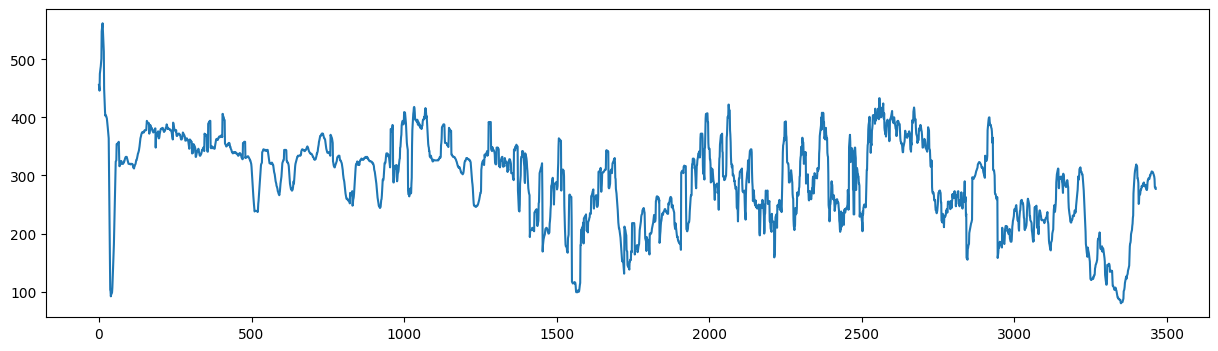

In [10]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["AQI"])
plt.show()

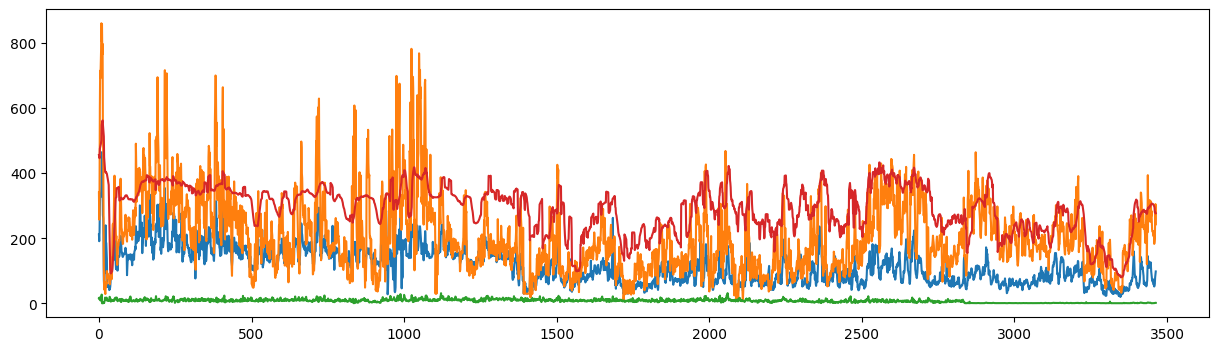

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [12]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:]) # do not transform y 
    data = scaler2.fit_transform(data.iloc[:,:3])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [13]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

validate_processed, validate_target_scalar, validate_scaler = data_process(validate, window_size, predict_size)
X_validate, y_validate = validate_processed['datain'], validate_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [14]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_validate = torch.from_numpy(X_validate.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_validate = torch.from_numpy(y_validate.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [15]:
print(X_train.shape)
X_train[0][0]

torch.Size([3454, 10, 3])


tensor([1.7459, 1.1779, 1.4834])

In [16]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)
        # self.fc_1 =  nn.Linear(in_features=self.hidden_units, out_features=128) # fully connected 
        # self.fc_2 = nn.Linear(in_features=128, out_features=1) # fully connected last layer
        # self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.
        # hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        # out = self.relu(hn)
        # out = self.fc_1(out) # first dense
        # out = self.relu(out) # relu
        # out = self.fc_2(out) # final output
        return out

In [17]:
class LSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, num_sensors=3, hidden_units=10, batch_size=5, learning_rate=0.001, optimizer_fn=torch.optim.Adam, num_epochs=50):
        self.num_sensors = num_sensors
        self.hidden_units = hidden_units
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.optimizer_fn = optimizer_fn
        self.num_epochs = num_epochs
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = ShallowRegressionLSTM(num_sensors, hidden_units).to(self.device)
        self.criterion = nn.MSELoss()
        
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        # Set up data loaders for training and validation
        train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), 
                                  batch_size=self.batch_size, shuffle=True)
        if X_val is not None and y_val is not None:
            val_loader = DataLoader(TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val)),
                                    batch_size=self.batch_size, shuffle=False)
        
        self.optimizer = self.optimizer_fn(self.model.parameters(), lr=self.learning_rate)
        
        self.train_losses = []
        self.val_losses = []
        for epoch in range(self.num_epochs):
            # Training phase
            self.model.train()
            epoch_train_loss = 0
            for x_batch, y_batch in train_loader:
                x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)
                self.optimizer.zero_grad()
                output = self.model(x_batch)
                loss = self.criterion(output, y_batch.squeeze(1)) # MSE
                loss.backward()
                self.optimizer.step()
                epoch_train_loss += loss.item() / len(train_loader)
            self.train_losses.append(epoch_train_loss)
            
            # Validation phase
            if X_val is not None and y_val is not None:
                self.model.eval()
                epoch_val_loss = 0
                with torch.no_grad():
                    for x_val, y_val in val_loader:
                        x_val, y_val = x_val.to(self.device), y_val.to(self.device)
                        val_output = self.model(x_val)
                        val_loss = torch.sqrt(self.criterion(val_output, y_val.squeeze(1)))  # RMSE
                        epoch_val_loss += val_loss.item() / len(val_loader)
                self.val_losses.append(epoch_val_loss)
            else:
                self.val_losses.append(float('nan'))  # For cases where validation data is absent
                
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.Tensor(X).to(self.device)
            predictions = self.model(X_tensor).cpu().numpy()
        return predictions

    def score(self, X, y):
        y_pred = self.predict(X)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        return -rmse  # Negative RMSE for compatibility with GridSearchCV scoring

# Define hyperparameters for grid search
param_grid = {
    'hidden_units': [1, 3, 6],
    'batch_size': [5, 10, 20],
    'learning_rate': [0.001, 0.004, 0.01],
    'optimizer_fn': [torch.optim.Adam, torch.optim.SGD]
}

# Initialize grid search
lstm_regressor = LSTMRegressor(num_sensors=3, num_epochs=50)
grid_search = GridSearchCV(lstm_regressor, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Fit the model
grid_search.fit(X_train, y_train, X_val=X_validate, y_val=y_validate)

# Output best parameters, train and validation losses
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Train Losses:", best_model.train_losses)
print("Validation Losses:", best_model.val_losses)

# Evaluate on the validation set
val_predictions = best_model.predict(X_validate)
val_loss = np.sqrt(mean_squared_error(y_validate, val_predictions))
print("Validation Loss (RMSE):", val_loss)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END batch_size=5, hidden_units=1, learning_rate=0.001, optimizer_fn=<class 'torch.optim.adam.Adam'>; total time=  23.7s
[CV] END batch_size=5, hidden_units=1, learning_rate=0.001, optimizer_fn=<class 'torch.optim.adam.Adam'>; total time=  22.5s
[CV] END batch_size=5, hidden_units=1, learning_rate=0.001, optimizer_fn=<class 'torch.optim.adam.Adam'>; total time=  22.4s
[CV] END batch_size=5, hidden_units=1, learning_rate=0.001, optimizer_fn=<class 'torch.optim.sgd.SGD'>; total time=  18.6s
[CV] END batch_size=5, hidden_units=1, learning_rate=0.001, optimizer_fn=<class 'torch.optim.sgd.SGD'>; total time=  18.8s
[CV] END batch_size=5, hidden_units=1, learning_rate=0.001, optimizer_fn=<class 'torch.optim.sgd.SGD'>; total time=  18.8s
[CV] END batch_size=5, hidden_units=1, learning_rate=0.004, optimizer_fn=<class 'torch.optim.adam.Adam'>; total time=  23.1s
[CV] END batch_size=5, hidden_units=1, learning_rate=0.004, optimizer

In [17]:
# Define a function to train the model with specific hyperparameters
def train_model(config, X_train, y_train, X_validate, y_validate, num_sensors):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = ShallowRegressionLSTM(num_sensors=num_sensors, hidden_units=config["hidden_units"]).to(device)
    criterion = nn.MSELoss()

    # Set up optimizer
    if config["optimizer"] == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    elif config["optimizer"] == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=config["learning_rate"])
    elif config["optimizer"] == "adagrad":
        optimizer = torch.optim.Adagrad(model.parameters(), lr=config["learning_rate"])    

    # Create data loaders
    train_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=config["batch_size"], shuffle=True)
    validate_dataloader = DataLoader(TensorDataset(X_validate, y_validate), batch_size=config["batch_size"], shuffle=False)

    # Track losses to observe trends
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(50):
        model.train()
        total_loss = 0
        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            label = y.squeeze(1)
            loss = torch.sqrt(criterion(output, label))  # RMSE
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, y in validate_dataloader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                label = y.squeeze(1)
                val_loss = torch.sqrt(criterion(output, label))
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(validate_dataloader)
        val_losses.append(avg_val_loss)

    return model, train_losses, val_losses

# Define grid search space
param_grid = {
    "hidden_units": [1, 3, 6],
    "learning_rate": [0.001, 0.004, 0.01],
    "batch_size": [5, 10,20,30],
    "optimizer": ["adam", "sgd","adagrad"],
}

# Perform grid search
best_model = None
best_config = None
best_val_loss = float("inf")
best_train_losses = []
best_val_losses = []

for config in product(*param_grid.values()):
    config = dict(zip(param_grid.keys(), config))
    
    model, train_losses, val_losses = train_model(config, X_train, y_train, X_validate, y_validate, num_sensors=3)
    print(f"Training with config: {config} Avg Train Loss {sum(train_losses) / len(train_losses)} Avg Validation Loss {sum(val_losses) / len(val_losses)} ")
    # Select the best model based on validation loss trend and value
    if min(val_losses) < best_val_loss and all(x >= y for x, y in zip(train_losses, train_losses[1:])) and all(x >= y for x, y in zip(val_losses, val_losses[1:])):
        best_model = model
        best_config = config
        best_val_loss = min(val_losses)
        best_train_losses = train_losses
        best_val_losses = val_losses

# Results
print("Best configuration:", best_config)

Training with config: {'hidden_units': 1, 'learning_rate': 0.001, 'batch_size': 5, 'optimizer': 'adam'} Avg Train Loss 0.5250864264308629 Avg Validation Loss 0.5145710005441391 
Training with config: {'hidden_units': 1, 'learning_rate': 0.001, 'batch_size': 5, 'optimizer': 'sgd'} Avg Train Loss 0.7326502369454215 Avg Validation Loss 0.740577415513242 
Training with config: {'hidden_units': 1, 'learning_rate': 0.001, 'batch_size': 5, 'optimizer': 'adagrad'} Avg Train Loss 0.9010942873203461 Avg Validation Loss 0.8648696266297173 
Training with config: {'hidden_units': 1, 'learning_rate': 0.001, 'batch_size': 10, 'optimizer': 'adam'} Avg Train Loss 0.5319510151678427 Avg Validation Loss 0.5181100040110383 
Training with config: {'hidden_units': 1, 'learning_rate': 0.001, 'batch_size': 10, 'optimizer': 'sgd'} Avg Train Loss 0.9881266518031936 Avg Validation Loss 0.9182451406523987 
Training with config: {'hidden_units': 1, 'learning_rate': 0.001, 'batch_size': 10, 'optimizer': 'adagrad'} 

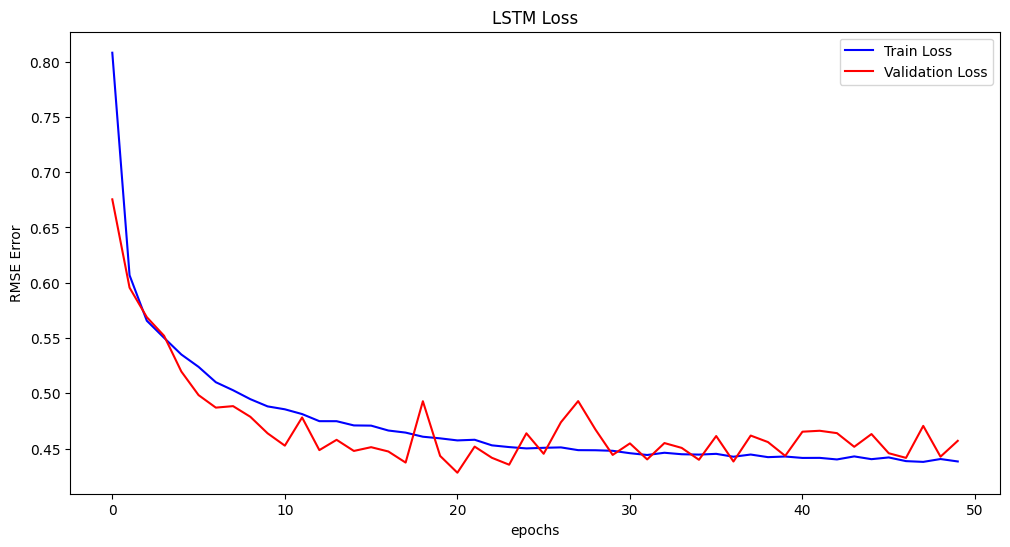

In [18]:
#np.savetxt('./SavedModels/Loss/clstm.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(best_model.train_losses, color = 'blue', label = 'Train Loss')
plt.plot(best_model.val_losses, color = 'red', label = 'Validation Loss')
plt.title('LSTM Loss')
plt.xlabel('epochs')
plt.ylabel('RMSE Error')
plt.legend(loc = 'upper right')

In [41]:
pred_y_train = best_model.predict(X_train)
pred_y_test = best_model.predict(X_test)

print(pred_y_train)

[ 1.2653813   1.4011288   1.4774065  ... -0.7300924  -0.625152
 -0.48680136]


In [42]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)
print(pred_y_train)

[[ 1.2653813 ]
 [ 1.4011288 ]
 [ 1.4774065 ]
 ...
 [-0.7300924 ]
 [-0.625152  ]
 [-0.48680136]]


In [55]:
pred_y_train.shape

(3454, 1)

In [53]:
y_train.cpu().detach().numpy().shape

(3454, 1)

In [56]:
MSE = mean_squared_error(pred_y_train, y_train)
RMSE = np.sqrt(MSE) 
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:0.4759257733821869


In [57]:
y_train_true = train_target_scalar.inverse_transform(y_train.cpu().detach().numpy())
y_train_pred = train_target_scalar.inverse_transform(pred_y_train)
y_test_true = test_target_scalar.inverse_transform(y_test.cpu().detach().numpy())
y_test_pred = test_target_scalar.inverse_transform(pred_y_test)

In [58]:
# np.savetxt('./SavedModels/Train/clstm.txt',y_train_pred)
# np.savetxt('./SavedModels/Test/clstm.txt',y_test_pred)

Training dataset RMSE:34.65827941894531


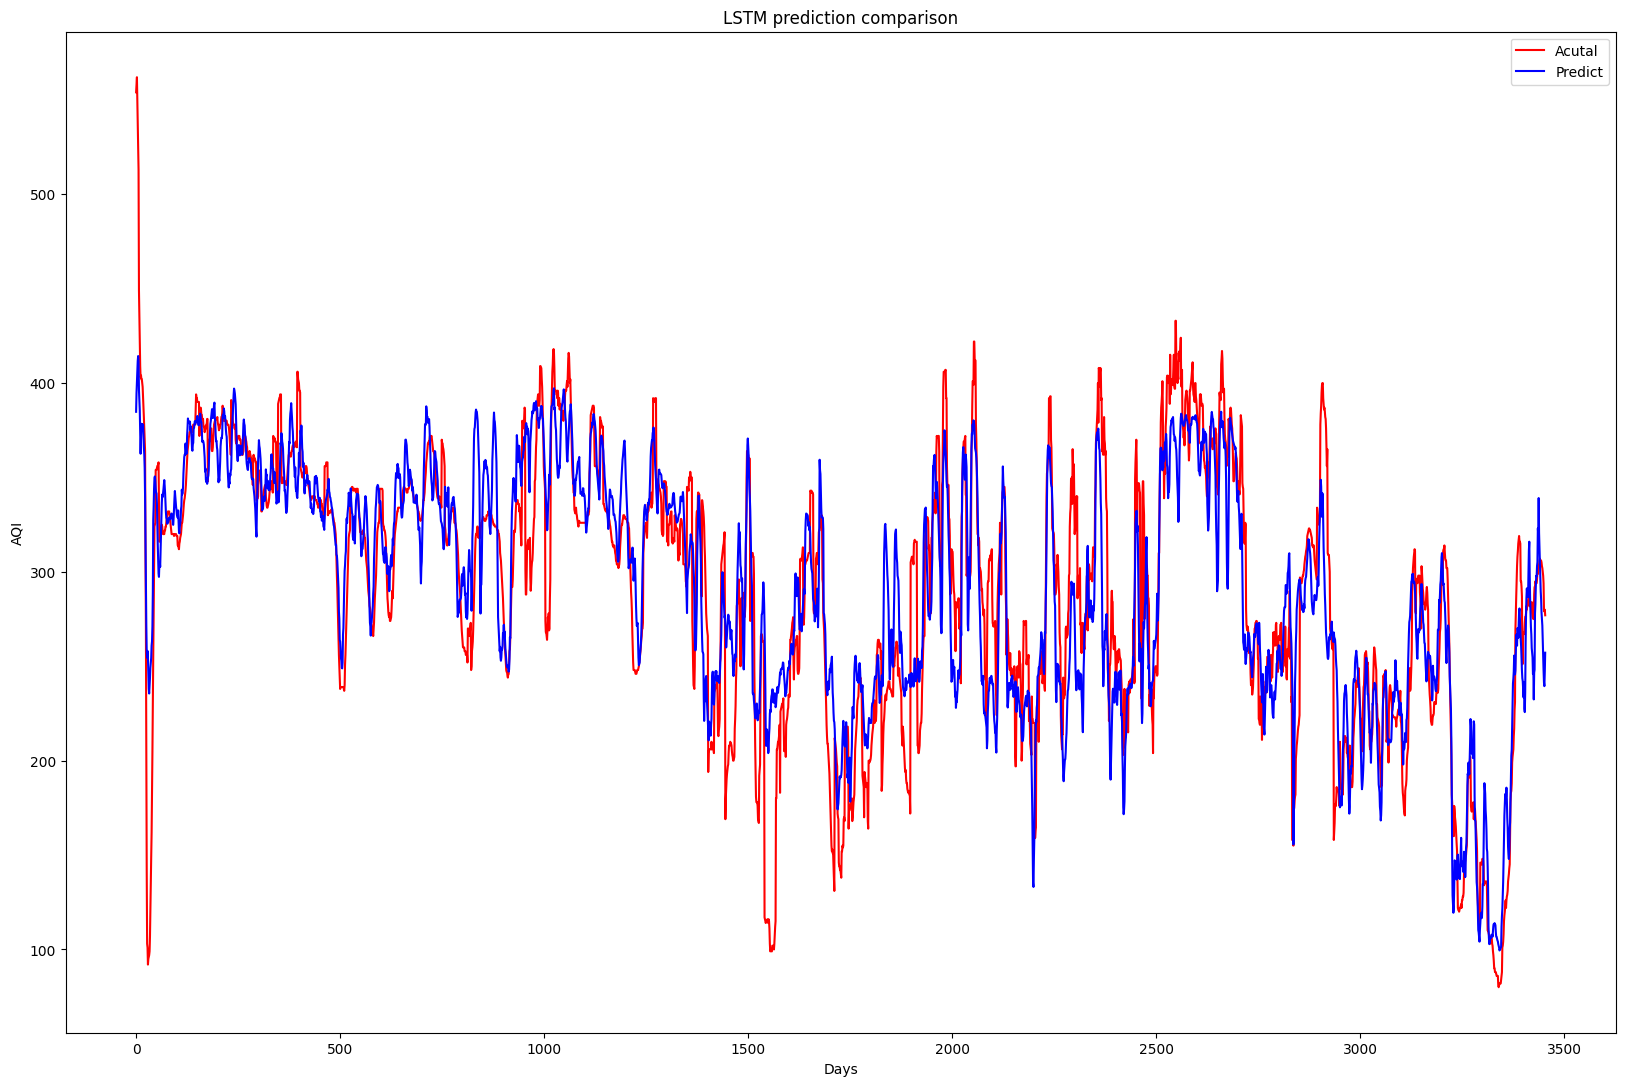

In [59]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('LSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = np.sqrt(MSE) 
print(f'Training dataset RMSE:{RMSE}')

Testing dataset RMSE:37.65392562847033


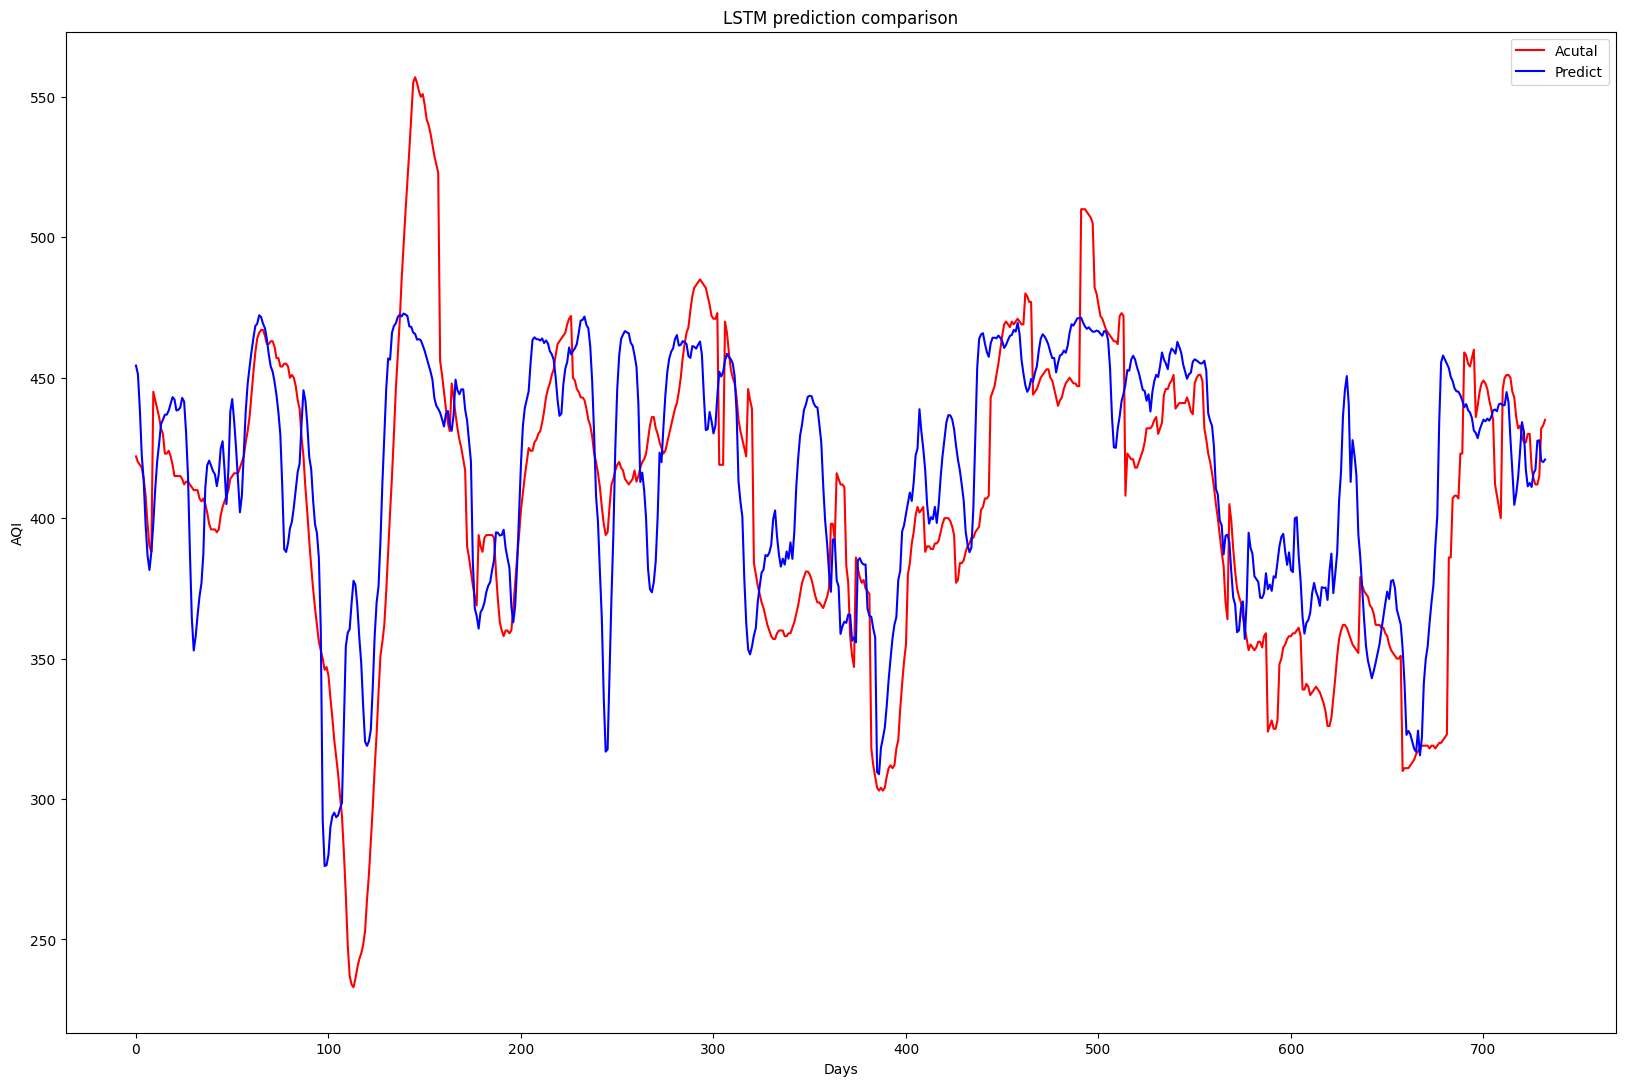

In [60]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('LSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Testing dataset RMSE:{RMSE}')

In [61]:
#torch.save(modelQ,'./SavedModels/AQI/CLSTM_aqi')